<a href="https://colab.research.google.com/github/diwert-ai/TestTask_PleuralEffSegmentation/blob/master/baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab preset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DATASET =     {'train': 'subset.zip'}
INPUT_DIR ='/content/drive/MyDrive/TestTask_PleuralEffusionSegmentation/input/'
OUTPUT_DIR = '/content/drive/MyDrive/TestTask_PleuralEffusionSegmentation/output/'

WORK_DIR='/content/'
EXPERIMENT='test4'
EXPERIMENT_DIR = OUTPUT_DIR + EXPERIMENT+'/'

DATASET_DIR = INPUT_DIR
METADATA_DIR = INPUT_DIR

IMPORT_DIR = '/content/drive/MyDrive/TestTask_PleuralEffusionSegmentation/nbs/py/'

In [4]:
def copy_dataset(ds_dict, ds_dir, work_dir):
  for record in ds_dict:
    print('copy', ds_dir+ds_dict[record], ' to', work_dir)
    !cp {ds_dir+ds_dict[record]} {work_dir}
    #print('mkdir',work_dir+record)
    #!mkdir {work_dir+record}
    print ('unzip -q ',work_dir+ds_dict[record],' -d ',work_dir)
    !unzip -q  {work_dir+ds_dict[record]} -d {work_dir}
    print ('rm ',work_dir+ds_dict[record])
    !rm {work_dir+ds_dict[record]}


copy_dataset(DATASET,DATASET_DIR, WORK_DIR)
!unzip -q  /content/subset/subset_img.zip -d /content/subset
!unzip -q  /content/subset/subset_masks.zip -d /content/subset
!ls /content/

copy /content/drive/MyDrive/TestTask_PleuralEffusionSegmentation/input/subset.zip  to /content/
unzip -q  /content/subset.zip  -d  /content/
rm  /content/subset.zip
drive  sample_data  subset


In [5]:
!ls /content/subset

subset	subset_img.zip	subset_masks  subset_masks.zip


In [6]:
!mkdir {EXPERIMENT_DIR}

# Install packages

In [7]:
!pip install --upgrade SimpleITK
!pip install --upgrade segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52.8 MB 206 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 6.8 MB/s 
     |████████████████████████████████| 58 kB 6.3 MB/s 
     |████████████████████████████████| 376 kB 57.0 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=0d996372795c039dd83b55901c0f868cc273c7da7c507b1a9cc3a9fac7dbee30
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=dda05336e0b8a50a1746995ec8e799ae165d6cb67302c7786f12a017cfad4695
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully

# Imports

In [8]:
import time
import random
import os
import gc
import glob
from collections import defaultdict
import numpy as np
import pandas as pd
import cv2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.animation as animation
from matplotlib import rc
rc('animation', html='jshtml')
import nibabel as nib
import SimpleITK as sitk
import torch
import torch.utils.data as data
import torch.nn as nn
from torch.cuda import amp
import torch.optim as optim
import segmentation_models_pytorch as smp
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Paths of input/output

In [9]:
paths = {'exp dir': EXPERIMENT_DIR,
         '3dimgs dir': '/content/subset/subset/',
         '3dmasks dir':'/content/subset/subset_masks/',
         '3dimgs files': '/content/subset/subset/L*/*/*/*',
         '3dmasks files': '/content/subset/subset_masks/L*/*gz',
         'imgs train': '/content/train',
         'masks train': '/content/train/masks'}

# Check mask and image slices 

In [10]:
def load_dicom(directory):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(directory)
    reader.SetFileNames(dicom_names)
    image_itk = reader.Execute()
    image_zyx = sitk.GetArrayFromImage(image_itk).astype(np.int16)
    return image_zyx

def show_img(x, mask=None, label=None):
    plt.imshow(x, cmap='bone')
    if mask is not None:
        plt.imshow(mask, alpha=0.4)
    plt.axis('off')
    plt.legend([Rectangle((0,0),1,1)], [label])

def show_slice(img, msk, label=None):
    msk = cv2.rotate(msk, cv2.ROTATE_90_COUNTERCLOCKWISE)
    plt.figure(figsize=(7 * 7, 7))
    plt.subplot(1, 5, 1)
    show_img(img, msk, label + ' masked')
    plt.subplot(1, 5, 2)
    show_img(img, None, label)

In [11]:
imgs_3d_paths = []
for path in glob.glob(paths['3dimgs files']):
  if path[-4:] != 'json':
    imgs_3d_paths.append(path)

In [12]:
masks_3d_paths = []
for path in glob.glob(paths['3dmasks files']):
  masks_3d_paths.append(path)

In [13]:
pref_img_len = len(paths['3dimgs dir'])
pref_msk_len = len(paths['3dmasks dir'])
lung_len = len('LUNG1-005')

In [14]:
def show_3d_masked_img_slices(img_3d_num, start_slice, stop_slice):
  test_imgs_path = imgs_3d_paths[img_3d_num]
  test_masks_path = masks_3d_paths[img_3d_num]
  lung_label = test_imgs_path[pref_img_len:pref_img_len + lung_len]
  test_imgs_3d  = load_dicom(test_imgs_path) 
  test_masks_3d = nib.load(test_masks_path)
  test_masks_3d = test_masks_3d.get_fdata().transpose(2, 0, 1 )
  for slice_num in range(start_slice, stop_slice):
    show_slice(test_imgs_3d[slice_num], test_masks_3d[slice_num], label=lung_label + ' ' + str(slice_num))

In [15]:
# show_3d_masked_img_slices(1, 50, 55)

In [16]:
def get_3d_masked_img_ani(img_3d_num, start_slice, stop_slice):
  test_imgs_path = imgs_3d_paths[img_3d_num]
  test_masks_path = masks_3d_paths[img_3d_num]
  test_imgs_3d  = load_dicom(test_imgs_path)
  max_slice_num = test_imgs_3d.shape[0] 
  test_masks_3d = nib.load(test_masks_path)
  test_masks_3d = test_masks_3d.get_fdata().transpose(2, 0, 1 )
  
  fig, ax = plt.subplots()
  ims = []
  lung_label = test_imgs_path[pref_img_len:pref_img_len + lung_len]
  plt.legend([Rectangle((0,0),1,1)], [lung_label])

  for slice_num in range(min(start_slice, max_slice_num), min(stop_slice, max_slice_num)):
      img, msk = test_imgs_3d[slice_num], test_masks_3d[slice_num]
      msk = cv2.rotate(msk, cv2.ROTATE_90_COUNTERCLOCKWISE)
      im1 = ax.imshow(img, cmap='bone',animated=True)
      im2 = ax.imshow(msk, alpha=0.4, animated=True)
      ims.append([im1, im2])

  ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                  repeat_delay=1000)
  return ani

In [17]:
# get_3d_masked_img_ani(1, 0, 200)

In [18]:
gc.collect()

176

# Saving slices

In [19]:
train_dir = paths['imgs train']

In [20]:
!mkdir {train_dir}

In [21]:
images_list = []
images_num = 0
save_images = True
for path in imgs_3d_paths:
    lung_name = path[pref_img_len:pref_img_len+lung_len]
    images = load_dicom(path) 
    print(f'3d shape:{images.shape}, path to file: {path}')
    images_num += images.shape[0]
    if save_images:
      for slice_number in tqdm(range(images.shape[0]), desc='imgs ', total = images.shape[0]):
        file_name = f'{train_dir}{lung_name.lower()}-{slice_number:03}.png'
        cv2.imwrite(file_name, images[slice_number])
        images_list.append(file_name)

print(f'{images_num}: total images')

3d shape:(134, 512, 512), path to file: /content/subset/subset/LUNG1-013/1.3.6.1.4.1.32722.99.99.22956175270943488134888072080774650081/05-25-2006/1.3.6.1.4.1.32722.99.99.112287954397873119496521416766962216008


imgs :   0%|          | 0/134 [00:00<?, ?it/s]

3d shape:(114, 512, 512), path to file: /content/subset/subset/LUNG1-008/1.3.6.1.4.1.32722.99.99.62087908186665265759322018723889952421/01-01-2014/1.3.6.1.4.1.32722.99.99.12747108866907265023948393821781944475


imgs :   0%|          | 0/114 [00:00<?, ?it/s]

3d shape:(134, 512, 512), path to file: /content/subset/subset/LUNG1-001/1.3.6.1.4.1.32722.99.99.239341353911714368772597187099978969331/09-18-2008/1.3.6.1.4.1.32722.99.99.298991776521342375010861296712563382046


imgs :   0%|          | 0/134 [00:00<?, ?it/s]

3d shape:(114, 512, 512), path to file: /content/subset/subset/LUNG1-018/1.3.6.1.4.1.32722.99.99.133861294009144872892099286118733055796/01-01-2014/1.3.6.1.4.1.32722.99.99.227681530875566672046643591102272845959


imgs :   0%|          | 0/114 [00:00<?, ?it/s]

3d shape:(82, 512, 512), path to file: /content/subset/subset/LUNG1-016/1.3.6.1.4.1.32722.99.99.33270408743325377945239702064361936302/01-01-2014/1.3.6.1.4.1.32722.99.99.284797801804879633380586221386972312178


imgs :   0%|          | 0/82 [00:00<?, ?it/s]

3d shape:(102, 512, 512), path to file: /content/subset/subset/LUNG1-028/1.3.6.1.4.1.32722.99.99.20703038533570730926856578144444872164/01-01-2014/1.3.6.1.4.1.32722.99.99.264835957627805388281392777511316792366


imgs :   0%|          | 0/102 [00:00<?, ?it/s]

3d shape:(95, 512, 512), path to file: /content/subset/subset/LUNG1-024/1.3.6.1.4.1.32722.99.99.70865403991822612162181296508600055010/01-01-2014/1.3.6.1.4.1.32722.99.99.307508393278515225148285519574169189883


imgs :   0%|          | 0/95 [00:00<?, ?it/s]

3d shape:(110, 512, 512), path to file: /content/subset/subset/LUNG1-026/1.3.6.1.4.1.32722.99.99.249238811613050564236336606937196066509/09-27-2004/1.3.6.1.4.1.32722.99.99.114316409421087493981687621847585550876


imgs :   0%|          | 0/110 [00:00<?, ?it/s]

3d shape:(91, 512, 512), path to file: /content/subset/subset/LUNG1-005/1.3.6.1.4.1.32722.99.99.71961866280433925571019872464419293819/01-01-2014/1.3.6.1.4.1.32722.99.99.34905847539837720676301269477428468747


imgs :   0%|          | 0/91 [00:00<?, ?it/s]

3d shape:(111, 512, 512), path to file: /content/subset/subset/LUNG1-002/1.3.6.1.4.1.32722.99.99.203715003805996641695765332389135385095/01-01-2014/1.3.6.1.4.1.32722.99.99.232988001551799080335895423941323261228


imgs :   0%|          | 0/111 [00:00<?, ?it/s]

1087: total images


In [22]:
train_dir_masks = paths['masks train']

In [23]:
!mkdir {train_dir_masks}

In [24]:
masks_num = 0
save_masks = True
masks_list = []
for path in masks_3d_paths:
  masks = nib.load(path)
  masks = masks.get_fdata().transpose(2, 0, 1)
  lung_name = path[pref_msk_len:pref_msk_len+lung_len]
  print(masks.shape, lung_name, path)
  masks_num += masks.shape[0]
  if save_masks:
    for slice_number in tqdm(range(masks.shape[0]), desc='msks ', total = masks.shape[0]):
      mask_file_name = f'{train_dir_masks}{lung_name.lower()}-{slice_number:03}.png' 
      mask = cv2.rotate(masks[slice_number], cv2.ROTATE_90_COUNTERCLOCKWISE)
      cv2.imwrite(mask_file_name, mask)
      masks_list.append(mask_file_name)

print(f'{masks_num}: total masks')

(134, 512, 512) LUNG1-013 /content/subset/subset_masks/LUNG1-013/LUNG1-013_effusion_first_reviewer.nii.gz


msks :   0%|          | 0/134 [00:00<?, ?it/s]

(114, 512, 512) LUNG1-008 /content/subset/subset_masks/LUNG1-008/LUNG1-008_effusion_first_reviewer.nii.gz


msks :   0%|          | 0/114 [00:00<?, ?it/s]

(134, 512, 512) LUNG1-001 /content/subset/subset_masks/LUNG1-001/LUNG1-001_effusion_first_reviewer.nii.gz


msks :   0%|          | 0/134 [00:00<?, ?it/s]

(114, 512, 512) LUNG1-018 /content/subset/subset_masks/LUNG1-018/LUNG1-018_effusion_first_reviewer.nii.gz


msks :   0%|          | 0/114 [00:00<?, ?it/s]

(82, 512, 512) LUNG1-016 /content/subset/subset_masks/LUNG1-016/LUNG1-016_effusion_first_reviewer.nii.gz


msks :   0%|          | 0/82 [00:00<?, ?it/s]

(102, 512, 512) LUNG1-028 /content/subset/subset_masks/LUNG1-028/LUNG1-028_effusion_first_reviewer.nii.gz


msks :   0%|          | 0/102 [00:00<?, ?it/s]

(95, 512, 512) LUNG1-024 /content/subset/subset_masks/LUNG1-024/LUNG1-024_effusion_first_reviewer.nii.gz


msks :   0%|          | 0/95 [00:00<?, ?it/s]

(110, 512, 512) LUNG1-026 /content/subset/subset_masks/LUNG1-026/LUNG1-026_effusion_first_reviewer.nii.gz


msks :   0%|          | 0/110 [00:00<?, ?it/s]

(91, 512, 512) LUNG1-005 /content/subset/subset_masks/LUNG1-005/LUNG1-005_effusion_first_reviewer.nii.gz


msks :   0%|          | 0/91 [00:00<?, ?it/s]

(111, 512, 512) LUNG1-002 /content/subset/subset_masks/LUNG1-002/LUNG1-002_effusion_first_reviewer.nii.gz


msks :   0%|          | 0/111 [00:00<?, ?it/s]

1087: total masks


# Create metadata frame

In [25]:
df_train = pd.DataFrame(data = {'image_path': images_list, 'mask_path': masks_list})
df_train['width'] = 512
df_train['height'] = 512
pref_len = len(train_dir)
df_train['group'] = df_train['image_path'].apply(lambda x: x[pref_len:pref_len+lung_len])
df_train['slice'] = df_train['image_path'].apply(lambda x: int(x.split('-')[2][:3]))
df_train.head()

,image_path,mask_path,width,height,group,slice
0,/content/trainlung1-013-000.png,/content/train/maskslung1-013-000.png,512,512,lung1-013,0
1,/content/trainlung1-013-001.png,/content/train/maskslung1-013-001.png,512,512,lung1-013,1
2,/content/trainlung1-013-002.png,/content/train/maskslung1-013-002.png,512,512,lung1-013,2
3,/content/trainlung1-013-003.png,/content/train/maskslung1-013-003.png,512,512,lung1-013,3
4,/content/trainlung1-013-004.png,/content/train/maskslung1-013-004.png,512,512,lung1-013,4


# Split frame on train/valid/test

In [26]:
def split(gr):
  if gr == 'lung1-026':
    return 'valid'
  elif gr == 'lung1-016':
    return 'test'
  else:
    return 'train'

In [27]:
df_train['split'] = df_train['group'].apply(lambda x: split(x))

In [28]:
df_train.to_csv(train_dir+'train.csv', index=False)
!cp {train_dir+'train.csv'} {INPUT_DIR}

# Train configuration

In [54]:
class Config:
    batch_size = 32
    image_size = 512
    num_workers = 2
    seed = 1276312
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model_arch = 'Unet'
    model_backbone = 'efficientnet-b0'
    num_classes = 1
    in_channels = 5
    pretrained = True
    epochs = 30
    val_freq = 1
    scheduler = 'ExponentialLR'
    debug = False
    lr = 0.001
    min_lr = 1e-6
    wd = 1e-6
    t_max = int(30000/batch_size*epochs)+50
    t_0   = 25
    warmup_epochs = 0
    aug_prob = 0.3
    crop_size = 1.0
    max_cutout = 20
    strong_aug = False

# Torch dataset construction

In [55]:
class PleuralEffDataset(data.Dataset):
    def __init__(self, df, transform=None, subset=100, s_deep = 2):
        self.transform = transform
        self.s_deep = s_deep
        if subset != 100:
            assert subset < 100
            num_rows = df.shape[0]*subset//100
            df = df.iloc[:num_rows]
        self.length = len(df)
        self.img_paths = df['image_path'].to_list()
        self.slice_nums = df['slice'].to_list()
        self.msk_paths = df['mask_path'].to_list()
    
    def load_slice(self, img_file, slice_num, diff):
        filename = img_file[:-7] + str(slice_num + diff).zfill(3) + '.png'
        if os.path.exists(filename):
            return cv2.imread(filename, cv2.IMREAD_UNCHANGED)
        return None

    
    def __getitem__(self, index):
        img_path = self.img_paths[index]
        slice_num = self.slice_nums[index]
        # read s_deep slices into one image
        imgs = [self.load_slice(img_path, slice_num, i) for i in range(-self.s_deep, self.s_deep+1)]

        for i in range(self.s_deep+1,2*self.s_deep+1):
            if imgs[i] is None:
                imgs[i] = imgs[i-1]
        for i in range(self.s_deep-1,-1,-1):
            if imgs[i] is None:
                imgs[i] = imgs[i+1]
        
        img = np.stack(imgs, axis=2)
        img = img.astype(np.float32)
        max_val = img.max()
        if max_val != 0:
            img /= max_val
        
        msk_path = self.msk_paths[index]
        mask = cv2.imread(msk_path, cv2.IMREAD_UNCHANGED)
        mask = mask.astype(np.float32)
        mask = mask.reshape(Config.image_size, Config.image_size, 1)
        result = self.transform(image=img, mask=mask)
        img, mask = result['image'], result['mask']
       
        return img, mask

    def __len__(self):
        return self.length

In [56]:
def make_train_augmenter():
    p = Config.aug_prob
    crop_size = round(Config.image_size*Config.crop_size)

    if p <= 0:
        return A.Compose([
            A.RandomCrop(height=crop_size, width=crop_size, always_apply=True),
            ToTensorV2(transpose_mask=True)
        ])

    aug_list = []
    if Config.max_cutout > 0:
        aug_list.extend([
            A.CoarseDropout(
                max_holes=Config.max_cutout, min_holes=1,
                max_height=crop_size//10, max_width=crop_size//10,
                min_height=4, min_width=4, mask_fill_value=0, p=0.2*p),
        ])

    aug_list.extend([
        A.ShiftScaleRotate(
            shift_limit=0.0625, scale_limit=0.2, rotate_limit=25,
            interpolation=cv2.INTER_AREA, p=p),
        A.RandomCrop(height=crop_size, width=crop_size, always_apply=True),
        A.HorizontalFlip(p=0.5*p),
        A.OneOf([
            A.MotionBlur(p=0.2*p),
            A.MedianBlur(blur_limit=3, p=0.1*p),
            A.Blur(blur_limit=3, p=0.1*p),
        ], p=0.2*p),
        A.Perspective(p=0.2*p),
    ])

    if Config.strong_aug:
        aug_list.extend([
            A.GaussNoise(var_limit=0.001, p=0.2*p),
            A.OneOf([
                A.OpticalDistortion(p=0.3*p),
                A.GridDistortion(p=0.1*p),
                A.PiecewiseAffine(p=0.3*p),
            ], p=0.2*p),
            A.OneOf([
                A.Sharpen(p=0.2*p),
                A.Emboss(p=0.2*p),
                A.RandomBrightnessContrast(p=0.2*p),
            ], p=0.3*p),
        ])

    aug_list.extend([
        ToTensorV2(transpose_mask=True)
    ])

    return A.Compose(aug_list)

def make_test_augmenter():
    crop_size = round(Config.image_size*Config.crop_size)  
    return  A.Compose([
        A.CenterCrop(height=crop_size, width=crop_size),
        ToTensorV2(transpose_mask=True)
    ])

In [57]:
train_aug, test_aug = make_train_augmenter(), make_test_augmenter()

In [58]:
def test_pl_dataset():
    dataset = PleuralEffDataset(df_train, transform=train_aug)
    loader = data.DataLoader(dataset,
                                sampler = data.RandomSampler(dataset),
                                batch_size = Config.batch_size,
                                drop_last   = True,
                                num_workers = Config.num_workers,
                                pin_memory  = True)
    
    def show_img(x, y=None):
        plt.imshow(x[:,:,0], cmap='bone')
        if y is not None:
            plt.imshow(y[:,:,0], alpha=0.4)
        plt.axis('off')
        
    def plot_batch(xs, ys, size=5):
        plt.figure(figsize=(10 * 10, 10))
        for idx in range(size):
            plt.subplot(1, 5, idx+1)
            x = xs[idx,].permute((1, 2, 0)).numpy()*255.0
            x = x.astype('uint8')
            y = ys[idx,].permute((1, 2, 0)).numpy()*255.0
            show_img(x, y)
        plt.tight_layout()
        plt.show()
    
    batch  = next(iter(loader))
    print(f'batch \'img\' dims: {batch[0].size()}\nbatch target \'mask\' dims: {batch[1].size()}')
    plot_batch(batch[0], batch[1])

batch 'img' dims: torch.Size([32, 5, 512, 512])
batch target 'mask' dims: torch.Size([32, 1, 512, 512])


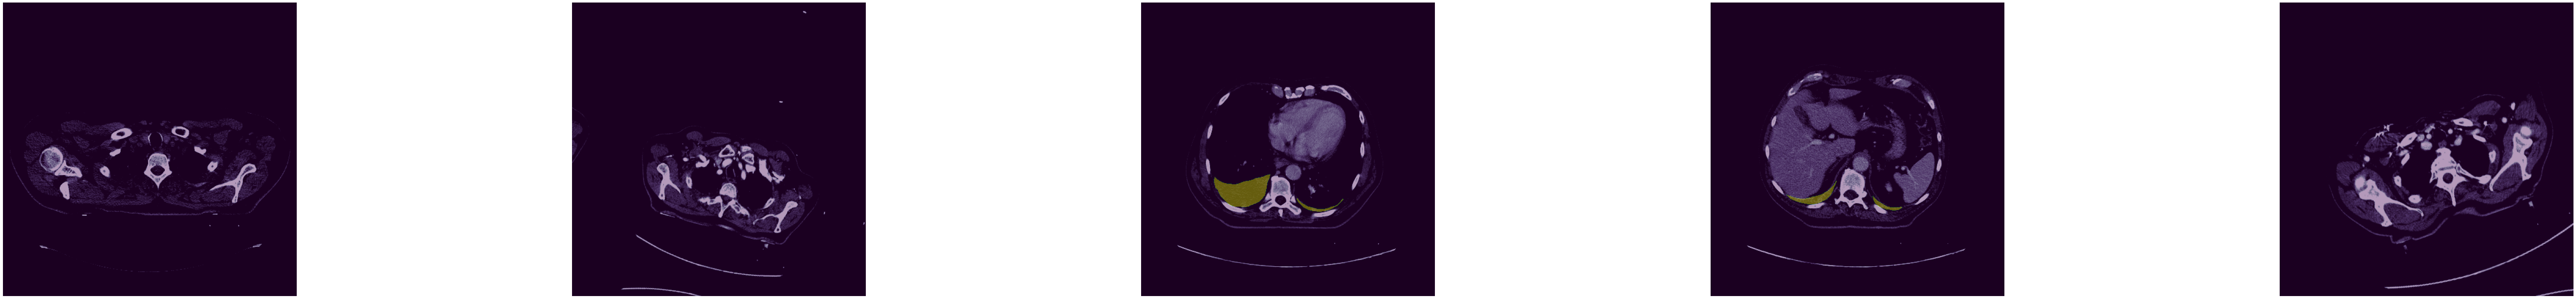

In [59]:
test_pl_dataset()

# Train & inference pipeline

In [60]:
def set_seed(seed = 42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(Config.seed)

In [61]:
# model, optimizer, scheduler, train_loader, valid_loader, test_loader = None, None, None, None, None, None

In [62]:
def prepare_loaders(debug=False):
    train_df = df_train.query("split=='train'").reset_index(drop=True)
    valid_df = df_train.query("split=='valid'").reset_index(drop=True)
    if debug:
        train_df = train_df.head(Config.batch_size*5)
        valid_df = valid_df.head(Config.batch_size*3)
    train_dataset = PleuralEffDataset(train_df, transform=train_aug)
    valid_dataset = PleuralEffDataset(valid_df, transform=test_aug)
    
    train_loader = data.DataLoader(train_dataset, 
                                   batch_size=Config.batch_size, 
                                   num_workers=2, 
                                   sampler = data.RandomSampler(train_dataset),
                                   pin_memory=True, 
                                   drop_last=False,
                                   worker_init_fn = lambda id: np.random.seed(torch.initial_seed() // 2 ** 32 + id))
    valid_loader = data.DataLoader(valid_dataset, 
                                   batch_size=Config.batch_size, 
                                   num_workers=2,
                                   sampler = data.SequentialSampler(valid_dataset),
                                   pin_memory=True)
    
    return train_loader, valid_loader

def prepare_testloader():
    test_df = df_train.query("split=='test'").reset_index(drop=True)
    test_dataset = PleuralEffDataset(test_df, transform=test_aug)
    test_loader = data.DataLoader(test_dataset, 
                                   batch_size=Config.batch_size,
                                   num_workers=2,
                                   sampler = data.SequentialSampler(test_dataset),
                                   pin_memory=True)
    return test_loader

In [63]:
class ModelWrapper(nn.Module):
    def __init__(self):
        super().__init__()
        if Config.model_arch == 'FPN':
            arch = smp.FPN
        elif Config.model_arch == 'Unet':
            arch = smp.Unet
        elif Config.model_arch == 'DeepLabV3':
            arch = smp.DeepLabV3
        else:
            assert 0, f'Unknown architecture {Config.model_arch}'

        weights = 'imagenet' if Config.pretrained else None
        self.model = arch(
            encoder_name = Config.model_backbone, encoder_weights=weights, in_channels=Config.in_channels,
            classes=Config.num_classes, activation=None)

    def forward(self, x):
        x = self.model(x)
        return  x

In [64]:
jaccard_loss = smp.losses.JaccardLoss(mode='binary')
dice_loss    = smp.losses.DiceLoss(mode='binary')
bce_loss     = smp.losses.SoftBCEWithLogitsLoss()
lovasz_loss  = smp.losses.LovaszLoss(mode='binary', per_image=False)
tversky_loss = smp.losses.TverskyLoss(mode='binary', log_loss=False)

In [65]:
def dice_coeff(labels, preds):
    return 2*(labels*preds).sum()/(labels.sum() + preds.sum() + 1e-6)

In [66]:
def criterion(y_pred, y_true):
    return dice_loss(y_pred, y_true)

In [67]:
def do_inference():
    model.eval()
    pbar = tqdm(enumerate(test_loader), total=len(test_loader), desc='Test ')
    test_dice_list = []
    sigmoid = nn.Sigmoid()
    with torch.no_grad():
        for step, (imgs, masks) in pbar:
            imgs  = imgs.to(Config.device, dtype=torch.float)
            masks = masks.to(Config.device, dtype=torch.float)
            y_pred = model(imgs)
            y_pred = sigmoid(y_pred).round().to(torch.float32)
            test_dice_list.append(dice_coeff(masks, y_pred).item())
    test_dice_mean  = np.mean(test_dice_list)
    torch.cuda.empty_cache()
    _ = gc.collect()
    return test_dice_mean

In [68]:
@torch.no_grad()
def do_valid():
    model.eval()
    valid_dice_list, valid_loss_list = [], []
    valid_dice_mean, valid_loss_mean = 0, 0
    sigmoid = nn.Sigmoid()
    dataloader_len = len(valid_loader)
    pbar = tqdm(enumerate(valid_loader), total=dataloader_len, desc='Valid ')

    for step, (imgs, masks) in pbar:        
        imgs = imgs.to(Config.device, dtype=torch.float)
        masks = masks.to(Config.device, dtype=torch.float)

        with amp.autocast(enabled=True):
            y_pred = model(imgs)

        valid_loss_list.append(criterion(y_pred, masks).item())
        valid_loss_mean = np.mean(valid_loss_list)
        y_pred = sigmoid(y_pred).round().to(torch.float32)
        valid_dice_list.append(dice_coeff(masks, y_pred).item())
        valid_dice_mean = np.mean(valid_dice_list)
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valloss=f'{valid_loss_mean:0.4f}',
                         valdice=f'{valid_dice_mean:0.4f}',
                         lr=f'{current_lr:0.5f}',
                         gpumem=f'{mem:0.2f} GB')
    
    torch.cuda.empty_cache()
    _ = gc.collect()
            
    return valid_loss_mean, valid_dice_mean

In [69]:
def train_one_epoch(epoch, best_metrics, history, valid_steps):
    model.train()
    scaler = amp.GradScaler()
    train_dice_list, train_loss_list = [], []
    train_dice_mean, train_loss_mean = 0, 0
    sigmoid = nn.Sigmoid()
    dataloader_len = len(train_loader)
    pbar = tqdm(enumerate(train_loader), total=dataloader_len, desc='Train ')
    for step, (imgs, masks) in pbar:         
        imgs = imgs.to(Config.device, dtype=torch.float)
        masks = masks.to(Config.device, dtype=torch.float)
        
        with amp.autocast(enabled=True):
            y_pred = model(imgs)
            loss   = criterion(y_pred, masks)
        
        train_loss_list.append(loss.item())
        train_loss_mean = np.mean(train_loss_list)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        y_pred = sigmoid(y_pred).round().to(torch.float32)
        train_dice_list.append(dice_coeff(masks, y_pred).item())
        train_dice_mean = np.mean(train_dice_list)


        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(trloss=f'{train_loss_mean:0.4f}',
                         trdice=f'{train_dice_mean:0.4f}',
                         lr=f'{current_lr:0.5f}',
                         gpumem=f'{mem:0.2f} GB')
        
        if step + 1 in valid_steps:
            valid_loss_mean, valid_dice_mean  = do_valid()
            history['Train Loss'].append(train_loss_mean)
            history['Train Dice'].append(float(train_dice_mean))
            history['Valid Loss'].append(valid_loss_mean)
            history['Valid Dice'].append(float(valid_dice_mean))
            history['Learning Rate'].append(current_lr)
            history['Memory Usage'].append(mem)
        
            if float(valid_dice_mean) > best_metrics['best_dice']:
                print(f"Valid Dice Coeff Improved: {best_metrics['best_dice']:0.4f} ---> {valid_dice_mean:0.4f}")
                best_metrics['best_dice'] = float(valid_dice_mean)  
                best_metrics['best_epoch'] = epoch

                suffix = f"best_valid_[ep_{epoch}]_{valid_dice_mean:0.4f}"
                model_filename = paths['exp dir']+suffix+'.bin'
                torch.save(model.state_dict(), model_filename)
                print('test dice: ', do_inference())
                model.train()
                  
    torch.cuda.empty_cache()
    _ = gc.collect()
    
    return

In [70]:
def run_training():
    if torch.cuda.is_available():
        print("cuda: {}\n".format(torch.cuda.get_device_name()))
    start = time.time()
    best_metrics =  {'best_dice': 0,               
                     'best_epoch': -1}
    history = defaultdict(list)
    train_len = len(train_loader)
    valid_steps = [train_len - i * train_len//Config.val_freq for i in range(Config.val_freq)]
    for epoch in range(1, Config.epochs + 1): 
        _ = gc.collect()
        print(f'Epoch {epoch}/{Config.epochs}', end='')
        train_one_epoch(epoch=epoch, best_metrics=best_metrics, history=history, valid_steps = valid_steps)
        scheduler.step()
        # save_last_state(model,optimizer,scheduler,epoch,history,best_params)            
        print('\n\n')
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Valid Dice: {:.4f}".format(best_metrics['best_dice']))

    return  history

In [71]:
def fetch_scheduler():
    if Config.scheduler == 'CosineAnnealingLR':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=Config.t_max, eta_min=Config.min_lr)
    elif  Config.scheduler == 'CosineAnnealingWarmRestarts':
        scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=Config.t_0, eta_min=Config.min_lr)
    elif  Config.scheduler == 'ReduceLROnPlateau':
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.333, patience=5, threshold=0.0001,
                                                           min_lr=0, verbose = True)
    elif  Config.scheduler == 'ExponentialLR':
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
    elif  Config.scheduler == None:
        return None
        
    return scheduler

In [72]:
test_loader = prepare_testloader()

In [73]:
histories = dict()
train_loader, valid_loader = prepare_loaders(debug=Config.debug)
model = ModelWrapper()
model.to(Config.device)
optimizer = optim.Adam(model.parameters(), lr=Config.lr, weight_decay=Config.wd)
scheduler = fetch_scheduler()
histories['main'] = run_training()

cuda: Tesla T4

Epoch 1/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]

Valid Dice Coeff Improved: 0.0000 ---> 0.1968


Test :   0%|          | 0/3 [00:00<?, ?it/s]

test dice:  0.16807321071003875



Epoch 2/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 3/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 4/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 5/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 6/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 7/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]

Valid Dice Coeff Improved: 0.1968 ---> 0.3033


Test :   0%|          | 0/3 [00:00<?, ?it/s]

test dice:  0.23122926553090414



Epoch 8/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 9/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 10/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 11/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]

Valid Dice Coeff Improved: 0.3033 ---> 0.5822


Test :   0%|          | 0/3 [00:00<?, ?it/s]

test dice:  0.3299182119468848



Epoch 12/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 13/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 14/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 15/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]

Valid Dice Coeff Improved: 0.5822 ---> 0.5960


Test :   0%|          | 0/3 [00:00<?, ?it/s]

test dice:  0.46658305327097577



Epoch 16/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 17/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 18/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 19/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 20/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]

Valid Dice Coeff Improved: 0.5960 ---> 0.6066


Test :   0%|          | 0/3 [00:00<?, ?it/s]

test dice:  0.47993338480591774



Epoch 21/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 22/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 23/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 24/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 25/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 26/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 27/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 28/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 29/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Epoch 30/30

Train :   0%|          | 0/28 [00:00<?, ?it/s]

Valid :   0%|          | 0/4 [00:00<?, ?it/s]




Training complete in 0h 16m 59s
Best Valid Dice: 0.6066


# Plot logs

In [74]:
def plot_and_save_histories():
    fig, axs = plt.subplots(2, len(histories), sharex=True, figsize=(20, 15))
    fig.suptitle('histories')

    def plot_history(keys, styles, num):
        x = list(range(len(histories[fold][keys[0]])))
        for i, key in enumerate(keys):
            y = histories[fold][key]
            axs[num].plot(x, y, styles[i], label=key)
        axs[num].set_title(fold)
        axs[num].legend()

    for n_fold, fold in enumerate(histories):
        plot_history(['Train Dice', 'Valid Dice'], ['o--', 'v:'], 0)
        plot_history(['Learning Rate'], ['o--'], 1)
    plt.show()
    fig.savefig(paths['exp dir'] + 'fig.png')

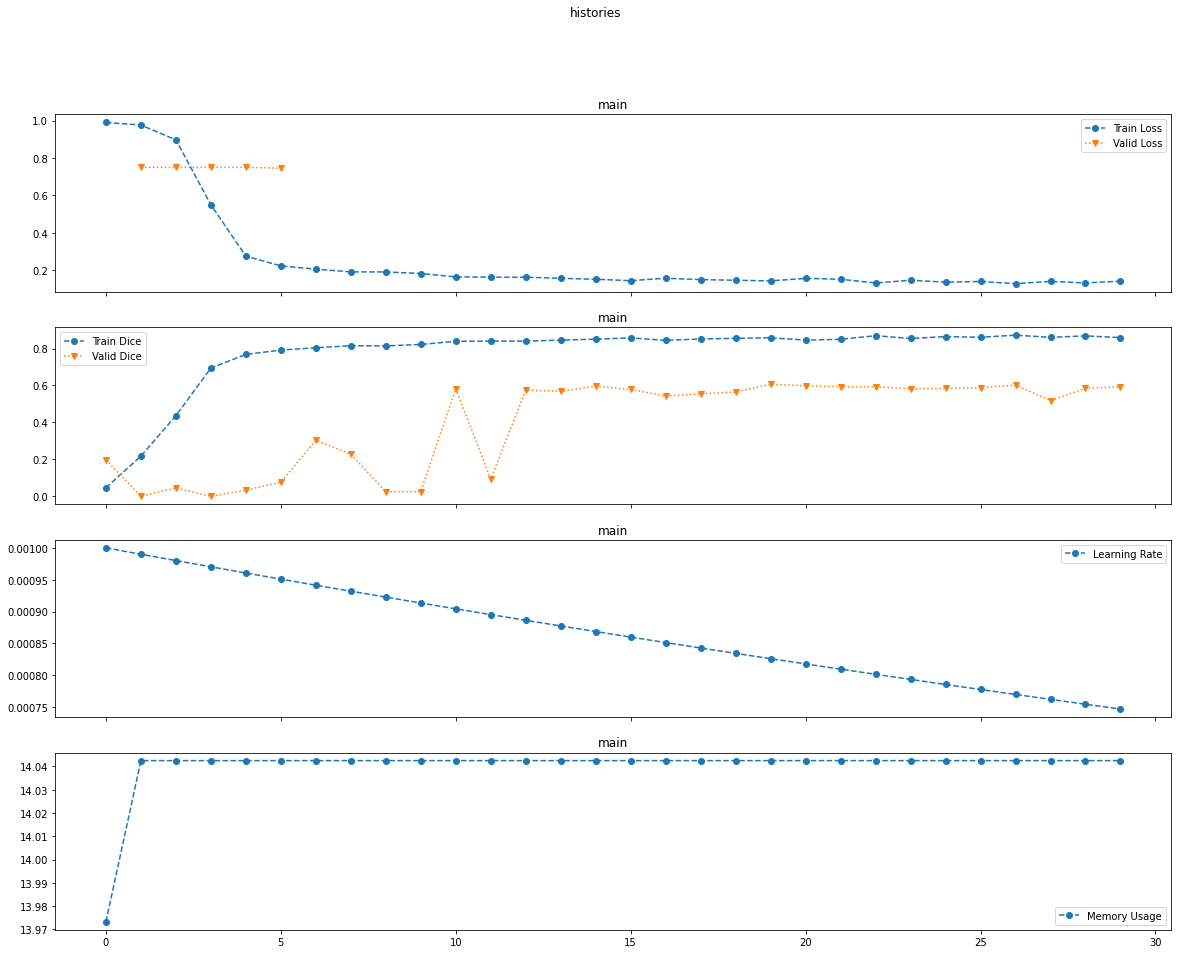

In [75]:
plot_and_save_histories()